<img src="../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Python Bootcamp and Summer Workshop on the Dynamic Brain</h1> 
<h3 align="center">August, 2018</h3> 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random

from bmtk.builder.networks import NetworkBuilder

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Modeling biophysically detailed cells with NEURON</h1>
In this tutorial, we will create a network of 8 cells. Four of these cells will be biophysically detailed and four will be Leaky-Intergrate-and-Fire (LIF) models. We will provide an external spiking input to this network and visualizat at the 8 neuron's resultant activity (spiking patterns and membrane potentials).
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Full_figure.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Build recurrent network</h1>
For building the 8 node network, we will save the nodes (neurons) and edges (connections) separately.  
</div>

In [2]:
# Output file names
directory_name = 'network/recurrent_network/'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
We will explore the directory structure of how files are being saved later. Just know for now that we will be creating files ans saving them in a directory called "network".
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Building Nodes</h2>
In this section we will be creating the nodes only. They are not receiving input nor connected to each other yet. The schematic below illustrates where we will be.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Neurons_created.png" alt=Drawing style="width: 350px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
The nodes are described by two files, one containing all information that are unique to nodes and one containing all information that are unique to models. We differentiate nodes and models because there can be a handful of models but thousands of nodes. With this, everything that is unique for nodes, such as position, goes in the nodes file. Parameters that are repeated (such as morphology, electrohphysiology parameters) can be stored and referenced in the model files (which we call node_types).
</div>

In [3]:
### Number of cell models desired
N_Scnn1a = 2
N_PV1 = 2
N_LIF_exc = 2
N_LIF_inh = 2

In [4]:
### Define all the cell models in a dictionary (note dictionaries within a dictionary)
biophysical_models = {
    
    # Cell type. Here we are using a pyrmaidal models from an Scnn1a Cre-line. Other
    # models exist in the components directory if you would like to explore them.
    'Scnn1a': { 
        # Number of nodes (neurons) we would like to create
        'N': N_Scnn1a,               
        # Key to indicate if the neuron is excitatory or inhibitory (optional)
        'ei': 'e', 
        # Key to store the population name of the model. One can have many
        # models from the same population (here cre-line)
        'pop_name': 'Scnn1a', 
        # Attribute to indicate this model is biophysical (instead of LIF for example)
        'model_type': 'biophysical',
        # Attribute to indicate that we will be using a NEURON template file created specially
        # for processing Cell Type Databases (ctdb) neuron models. For different type of models
        # and simulators we will want to change this value (or use our own templates)
        'model_template': 'ctdb:Biophys1.hoc',
        # For special post-processing imperatives and functions can be set in model_processing.
        # In this case we are telling the simulator to specially cut the axon as required for 
        # Cell Types models (built in function). We can also pass in custom functions
        'model_processing': 'aibs_perisomatic',       
        # The morpholgy file for this model (NEURON template). This is stored in the components
        # directory if you would like to explore it more (plus other models). 
        'morphology_file': 'Scnn1a-Tg3-Cre_Ai14_IVSCC_-177300.01.02.01_473845048_m.swc',
        # The dynamics parameters file for this model. Again, this is stored
        # in the components directory with other models if you wish to check them out.
        'dynamics_params': '472363762_fit.json',
        # Fixed for every model but needs to be defined. This is the angle of the 
        # morphology reconstruction relative to the pia.
        'rotation_angle_zaxis': -3.646878266
    },
    
    # Below are the same attributes but with different values for the PV cell we will be
    # modeling in our network.
    'PV1': {
        'N': N_PV1,
        'ei': 'i', 
        'pop_name': 'PV1',
        'model_type': 'biophysical',
        'model_template': 'ctdb:Biophys1.hoc',
        'model_processing': 'aibs_perisomatic',
        'dynamics_params': '472912177_fit.json',
        'morphology_file': 'Pvalb-IRES-Cre_Ai14_IVSCC_-176847.04.02.01_470522102_m.swc',
        'rotation_angle_zaxis': -2.539551891
    }
}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Example function for illustrative purposes</h1>
The below is simply a function that will return random coorindates for nodes. The purpose of this functions is to show you how to use the API to create your own custom functions. It will be used in the subsequent cell.
</div>

In [5]:
def generate_random_positions(N):
    '''
    Generate N random positions.
    N: number of positions to generate
    '''

    x = np.random.random(N)     # x-axis location
    y = np.random.random(N)     # y-axis location
    z = np.random.random(N)     # z-axis location

    positions = np.column_stack((x, y, z))

    return positions

In [6]:
### Create nodes set for each biophysical population

# A network object is created. This will store all the 
# information about the nodes and connections between nodes. The object has
# multiple methods (functions) that we will be using below to build the network
# nodes first and connections second.
net = NetworkBuilder('Cortical')

# We will loop through every model and create nodes. Note the main function
# below is net.add_nodes()
for model in biophysical_models:
    # Read the first biophysical model parameters dictionary
    params = biophysical_models[model]
    
    n_cells = params.pop('N')
    # Calculate positions for every cell (x, y, z). The called function was created
    # above. It doesn't do anything special other than create positions for nodes
    # from a random number generator. But one can write more sophisticated algorithms
    # for positions if they choose.
    positions = generate_random_positions(n_cells)

    # Adds node populations giving it all the input paramters one would like.
    net.add_nodes(N=n_cells, # Specify the numer of cells belonging to this set of nodes 
                  # for the positions and y rotation we are passing in arrays of size N, which mean
                  # such properties are unique for every cell
                  x=positions[:,0], y=positions[:, 1], z=positions[:, 2],
                  rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, n_cells),
                  # The other parameters are shared by all cells of this set in the dictionary
                  **params) # python shortcut for unrolling a dictionary

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 1: </h3>
<p>Create the LIF cells  
<p>Add a population of excitatory and inhibitory LIF neurons. 
<h4>Exercise 1.1: </h4>
<p>First create a dictionary as done in the biophysical example
<p>Some names are unique based on the components files that have been provided to you and so please use:  
<p>**'model_type'**: 'point_process'. 
<p> Instead of being a biophysicall detailed cells, LIF cells are point processes. We can also use model types of point soma (has biophysical mechanics but no morphology) or virtual (for providing spike trains) 

<p>**'model_template'**: 'nrn:IntFire1',  
<p>**'dynamics_params'**: 'IntFire1_exc_1.json' and 'IntFire1_inh_1.json'
<p> Here we tell the simulation to use NEURON built-in IntFire1 type models:

  
<p>Note that you do not need to add a morphology file or rotation angle for the z-axis here.
</div>

In [7]:
### Define all the cell models in a dictionary.
LIF_models = {
    'LIF_exc': {
        'N': N_LIF_exc, 
        'ei': 'e', 
        'pop_name': 'LIF_exc',
        'model_type': 'point_process',
        'model_template': 'nrn:IntFire1',
        'dynamics_params': 'IntFire1_exc_1.json'
    },
    'LIF_inh': {
        'N': N_LIF_inh,
        'ei': 'i', 
        'pop_name': 'LIF_inh',
        'model_type': 'point_process',
        'model_template': 'nrn:IntFire1',
        'dynamics_params': 'IntFire1_inh_1.json'
    }
}

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 2:</h3>
Loop through the dictionary as done before to add the cells.
<p>In practice one will use one for-loop and dictionary for all node-types.
</div>

In [8]:
### Create a node set for each point population
for model in LIF_models:
    params = LIF_models[model].copy()

    # Number of cells for this model type
    n_cells = params.pop('N')

    # Precacluate positions, rotation angles for each N neurons in the population
    positions = generate_random_positions(n_cells)

    # Adds node populations
    net.add_nodes(N=n_cells ,
                  x=positions[:,0], y=positions[:, 1], z=positions[:, 2],
                  rotation_angle_yaxis=np.random.uniform(0.0, 2*np.pi, n_cells),
                  **params)  # python shortcut for unrolling a dictionary

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Saving nodes in hdf5 file</h2>
To save the nodes, it is important to highlight the difference between nodes and models.
<p> Nodes refers to the specific neuron instantiations that are created and will have specific properties such as position coordinates. Each neuron still corresponds to a specific model though.  
<p> Models describe the properties of sets of neurons that are common. In our case, these include the electrophysiological parameters and the morphology. This is because, as mentioned above, we use the same model to create multiple cells of those models.  
<p>As such, in the save functions below, we save the neurons (cells) and the models (types). This create two files which we will examine. Note that both have node_type_id (created automatically) as a common column which will tell the simulator that the node selected corresponds to a specific node type which it can reference from the node_types table.
</div>

In [9]:
net.save_nodes(nodes_file_name='nodes.h5', node_types_file_name='node_types.csv', output_dir=directory_name)

In [10]:
# Show the nodes file
from bmtk.analyzer import nodes_table
nodes_table('network/recurrent_network/nodes.h5', 'Cortical')

,node_id,node_type_id,rotation_angle_yaxis,x,y,z
0,0,100,1.250683,0.364398,0.490329,0.204657
1,1,100,0.488530,0.625372,0.028014,0.093481
2,2,101,4.932349,0.629621,0.943629,0.278067
3,3,101,6.057071,0.253373,0.144111,0.243941
4,4,102,2.224025,0.956474,0.043349,0.925082
5,5,102,1.157210,0.460888,0.036063,0.851202
6,6,103,4.847870,0.453416,0.690032,0.139465
7,7,103,3.590353,0.583308,0.963537,0.429944


In [11]:
# Show the node_types file. Note the common column is node_type_id
node_types_DF = pd.read_csv('network/recurrent_network/node_types.csv', sep = ' ')
node_types_DF

,node_type_id,pop_name,dynamics_params,morphology_file,ei,model_processing,model_type,model_template,rotation_angle_zaxis
0,100,Scnn1a,472363762_fit.json,Scnn1a-Tg3-Cre_Ai14_IVSCC_-177300.01.02.01_473...,e,aibs_perisomatic,biophysical,ctdb:Biophys1.hoc,-3.646878
1,101,PV1,472912177_fit.json,Pvalb-IRES-Cre_Ai14_IVSCC_-176847.04.02.01_470...,i,aibs_perisomatic,biophysical,ctdb:Biophys1.hoc,-2.539552
2,102,LIF_exc,IntFire1_exc_1.json,NaN,e,NaN,point_process,nrn:IntFire1,NaN
3,103,LIF_inh,IntFire1_inh_1.json,NaN,i,NaN,point_process,nrn:IntFire1,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Setting connections (edges)</h2>
Now we will create edges between all nodes as in the figure below (note actual connecions will be different).
Similar to nodes, the edge files are saved into two files, one that describes unique edges between nodes (e.g. node 315 connects to node 938) and the other that describes the properties of different edges.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Recurrent_connected.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
Similar to nodes, the edge files are saved into two files, one that describes unique edges between nodes (e.g. node 315 connects to node 938) and the other that describes the properties of different edges.
</div>

In [12]:
# Edges files
edge_types_file = directory_name + 'edge_types.csv'   # Contains info. about every edge type
edges_file = directory_name + 'edges.h5'             # Contains info. about every edge created

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Example function for illustrative purposes</h1>
The below is simply a function that will determine whether or not two nodes are connected to one another. If they are connected the number of synapses forming the connection is also determined. In this function, d_max is a cut-off that determines if the neurons are close enough to connect or not connect. Below, you will see that we choose a very large d_max such that all neurons are connected to one another. The purpose of this functions is to show you how to use the API to create your own custom functions. It will be used in the subsequent cells.
</div>

In [13]:
def distance_connection_handler(source, target, d_max, nsyn_min, nsyn_max):
    '''
    Connect cells that are less than d_max apart
    with a random number of synapses in the 
    interval [nsyn_min, nsyn_max)
    '''
    
    sid = source['node_id']    # Get source id
    tid = target['node_id']    # Get target id
    
    # Avoid self-connections.
    if (sid == tid):
        return None

    # first calculate euclidean distance between cells
    src_positions = np.array([source['x'], source['y'], source['z']])
    trg_positions = np.array([target['x'], target['y'], target['z']])
    separation = np.sqrt(np.sum(src_positions - trg_positions)**2 )

    # drop the connection if nodes too far apart
    if separation >= d_max:
        return

    # Add the number of synapses for every connection.
    tmp_nsyn = random.randint(nsyn_min, nsyn_max)
    return tmp_nsyn

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating I-to-I connections</h3>
</div>

In [14]:
# The cparameters dictionary is the connection parameters dictionary which will be 
# used between connected nodes. In this API, this is how arguments/variables are given to
# the connection function (defined earlier and will be used below). 
# Here the function that will use these parameters was defined at the start of the notebook
# and was called distance_connection_handler().

cparameters = {'d_max': 160.0,    # Maximum separation between nodes where connection allowed 
               'nsyn_min': 3,     # If connection exist, minimum number of synapses
               'nsyn_max': 7}     # If connection exist, maximum number of synapses

In [15]:
# Here we will give a connection rule we want to impose on the network. Note that
# we only give the rules (with associated functions) and the network object created earlier. The API
# will then loop and determine the connections that satify the rules.

net.add_edges(
    # Connection rule states A: Everytime the source node (pre-synaptic neuron) is inhibitory
    source={'ei': 'i'}, 
    # Connection rule states B: Everytime the target node (post-synamtic neuron) is
    # inhibitory and of biophysical detail. One can change this of course to another
    # rule that depends on pop_name or node_mode_id only for instance.
    target={'ei': 'i', 'model_type': 'biophysical'},
    # Function that will determine the rules of connectivity. This was defined before
    # and required 5 arguments. However, note that the source node and target
    # node will be automatically set as arguments to the function and hence only
    # need 3 arguments. 
    connection_rule=distance_connection_handler,
    # The remaining arguments needed by distance_connection_handler that we defined above.
    connection_params=cparameters,
    # Till now we only determined if node X is connected to node Y.
    # The parameters of the connections are defined below (edge_parameters)
    # syn_weight defines the strength of the connection. It depends on the 
    # target cell mechanism. Here, this will be interpreted as the peak
    # conductance measure in uS.
    syn_weight=0.03, 
    # When the target is a biophysical neuron, the location of the connections 
    # (synapses) along the neuron must be defined.
    distance_range=[0.0, 1e+20],
    # Further, when the target is a biophysical neuron, the regions of the 
    # neuron being targeted need to be defined.
    target_sections=['somatic', 'basal'], 
    # Axonal delay between when pre-synaptic node fires and post-synaptic
    # target responds. The unit is milliseconds
    delay=2.0,
    # File that contains the parameters for the synaptic weight which you can
    # explore in the components directory. The naming convention below indicates
    # that the synapse dynamics are GABA for an Inh to Inh node.
    dynamics_params='GABA_InhToInh.json', 
    # params_file only has parameter values, but the mechanism (profile) of
    # synaptic dynamics are defined in NEURON. Here we use exp2syn where you
    # can find more info here:
    # https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/mech.html#Exp2Syn
    model_template='exp2syn'
)

In [16]:
# When the target is a LIF neuron. Note here that distance_range and target_sections are
# not needed. Also, due to how NEURON handles LIF neurons, the synaptic profile has an
# instantaneous increase (after the synaptic delay) and no params_function is neeeded.
net.add_edges(source={'ei': 'i'}, 
              target={'ei': 'i', 'model_type': 'point_process'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.3, 
              delay=2.0,
              dynamics_params='instanteneousInh.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating I-to-E connections</h3>
</div>

In [17]:
# As above, need to give different rules for when the target is a biophysical neuron.
net.add_edges(source={'ei': 'i'}, 
              target={'ei': 'e', 'model_type': 'biophysical'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.3, 
              distance_range=[0.0, 50.0],
              target_sections=['somatic', 'basal', 'apical'], 
              delay=2.0,
              dynamics_params='GABA_InhToExc.json',
              model_template='exp2syn')

In [18]:
# As above, need to give different rules for when the target is a LIF neuron.
net.add_edges(source={'ei': 'i'}, 
              target={'ei': 'e', 'model_type': 'point_process'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.4,
              delay=2.0,
              dynamics_params='instanteneousInh.json')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 2:</h3>
<p> Complete the remaining connections: E-to-I, and E-to-E  
<h4> Hints:  </h4>
<p>-You can use the same cparameters values  
<p>-Available params_files are: GABA_InhToInh.json, GABA_InhToExc.json, AMPA_ExcToInh.json, AMPA_ExcToExc.json, instanteneousInh.json, instanteneousExc.json  
<p>-Inhibitory neurons only have 'somatic' and 'basal' compartments. Excitatory neurons also have 'apical'.  
<p>-When the target neuron is inhibitory and biophysical, suggested distance range is [0.0, 1e+20] that targets somatic and basal compartments.  
<p>-When the target neuron is exctiatory, suggested distance range is [30.0, 150.0] that targets basal and apical compartments.  
<p>-Suggested weights, but you can experiment,: E-to-I biophysical = 0.05, E-to-I LIF =0.2, E-to-E biphysical = 0.05, E-to-E LIF = 0.05
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating E-to-I connections</h3>
</div>

In [19]:
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'PV1'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.05,
              distance_range=[0.0, 1e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='AMPA_ExcToInh.json', 
              model_template='exp2syn')

net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_inh'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.2,
              delay=2.0,
              dynamics_params='instanteneousExc.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Generating E-to-E connections</h3>
</div>

In [20]:
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'Scnn1a'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.05,
              distance_range=[30.0, 150.0], 
              target_sections=['basal', 'apical'], 
              delay=2.0,
              dynamics_params='AMPA_ExcToExc.json',
              model_template='exp2syn')

net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_exc'},
              connection_rule=distance_connection_handler,
              connection_params=cparameters,
              syn_weight=0.05, 
              delay=2.0,
              dynamics_params='instanteneousExc.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Building network...</h2>
</div>

In [21]:
# This will actually build the network and determine which nodes are connected to which. 
# Until now, only the rules were given and stored.
net.build()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Saving edges</h2>
</div>

In [22]:
# Save the edges and edge_types file.
net.save_edges(edges_file_name='edges.h5', edge_types_file_name='edge_types.csv', output_dir=directory_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
Below we only show the edge_types file as the description of the edges is in a .h5 file format and can't be show here. If you have any questions about it, please ask us and we are happy to give you more detailed about how it is saved. If you would like to see how they are saved, you
will need to install special software (HDFviewer or Vitables are good options.)
</div>

In [23]:
# Viewing the edge_types file
edge_types_DF = pd.read_csv('network/recurrent_network/edge_types.csv', sep = ' ')
edge_types_DF

,edge_type_id,target_query,source_query,distance_range,syn_weight,dynamics_params,target_sections,model_template,delay
0,100,ei=='i'&model_type=='biophysical',ei=='i',"[0.0, 1e+20]",0.03,GABA_InhToInh.json,"['somatic', 'basal']",exp2syn,2.0
1,101,ei=='i'&model_type=='point_process',ei=='i',NaN,0.30,instanteneousInh.json,NaN,NaN,2.0
2,102,ei=='e'&model_type=='biophysical',ei=='i',"[0.0, 50.0]",0.30,GABA_InhToExc.json,"['somatic', 'basal', 'apical']",exp2syn,2.0
3,103,ei=='e'&model_type=='point_process',ei=='i',NaN,0.40,instanteneousInh.json,NaN,NaN,2.0
4,104,pop_name=='PV1',ei=='e',"[0.0, 1e+20]",0.05,AMPA_ExcToInh.json,"['somatic', 'basal']",exp2syn,2.0
5,105,pop_name=='LIF_inh',ei=='e',NaN,0.20,instanteneousExc.json,NaN,NaN,2.0
6,106,pop_name=='Scnn1a',ei=='e',"[30.0, 150.0]",0.05,AMPA_ExcToExc.json,"['basal', 'apical']",exp2syn,2.0
7,107,pop_name=='LIF_exc',ei=='e',NaN,0.05,instanteneousExc.json,NaN,NaN,2.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Build input driving sources</h1>
In a parallel manner to before, we will now create the input network and connect it to the excitatory cells we have already made. 
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/External_input_connected.png" alt=Drawing style="width: 500px;">

In [24]:
# Will save the output files in a parallel manner to what we did before.
# Output file names
directory_name = 'network/source_input/'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Builing input sources</h2>
</div>

In [25]:
# Create input nodes dictionary. Will use "virtual" in this example and the dictionary 
# has already been created for you below. In the following you will create the nodes
# and save them as was done for the recurrent network. Note that we are making 25 
# external nodes and we will give them Poission spike trains.

filter_models = {
    'inputFilter': {
        'N': 25, 
        'ei': 'e', 
        'pop_name': 'input_filter', 
        'model_type': 'virtual'
    }
}

In [26]:
# Create a network object
inputNetwork = NetworkBuilder("inputNetwork")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 3:</h3>
Create and an external network with the dictionary parameters given above. Note that here less parameters are needed than before.
</div>

In [27]:
# Add each cell type to the network

# SOLUTION 1:
# for model, params in filter_models.items():
#     inputNetwork.add_nodes(**params)

# SOLUTION 2:
inputNetwork.add_nodes(**filter_models['inputFilter'])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Exercise 4:</h3>
<p> Save the input network as done before.
</div>

In [28]:
inputNetwork.save_nodes(nodes_file_name='nodes.h5', node_types_file_name='node_types.csv', output_dir=directory_name)

In [29]:
# Print the first 5 external nodes
input_nodes_DF=nodes_table('network/source_input/nodes.h5', 'inputNetwork')
input_nodes_DF[:5]

,node_id,node_type_id
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100


In [30]:
# Print the external node types
input_node_types_DF = pd.read_csv('network/source_input/node_types.csv', sep = ' ')
input_node_types_DF

,node_type_id,pop_name,ei,model_type
0,100,input_filter,e,virtual


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Connect input sources to recurrent network</h2>
Although it is already in memory, we will load the recurrent network again under a different name to illustrate how one can load older networks.
</div>

In [31]:
# Defining a function that will select source sources to connect to the network.
# In this example, all source cells will connect but this gives you an idea of
# how custom functions can be created to select subsets of input sources nodes.
# Also we here introduce a new concept for connecting nodes. Here the function
# receives all sources and a single target. An algorithm can determine which
# sources connect to the given target. The function will return a list of length
# equal to the number of sources. The elements in the list can be either N_syn
# everytime there is a connection or None when there is no connection.
def select_source_cells(sources, target, N_syn):
    '''
    Note here that "sources" are given (not "source"). So the iterations occur through every target 
    with all sources as potential inputs. Faster than before and better if will have common rules.
    '''

    target_id = target.node_id
    source_ids = [s.node_id for s in sources]

    nsyns_ret = [N_syn]*len(source_ids)
    return nsyns_ret

In [32]:
# Similar to as was done for the recurrent network.  
cparams = {'N_syn': 10}

In [33]:
# Connect the external population to the biophysical exctitaory nodes (Scnn1a).
# This is the same format as before, but note that this time we give an input
# to the connect function called "iterator". Previously, when we did not use this
# and the default "one_to_one" was used. When in the default "one_to_one" case, the 
# connector function iterates through every source and target one by one. When
# the iterator is "all_to_one", the connector function will expect all sources
# to be received together for every target. Other options are "one_to_all". The
# final option "all_to_all" is still not available.
inputNetwork.add_edges(target=net.nodes(pop_name='Scnn1a'),
                       iterator='all_to_one',
                       connection_rule=select_source_cells,
                       connection_params=cparams,
                       syn_weight=0.0007, 
                       distance_range=[0.0, 150.0],
                       target_sections=['basal', 'apical'],
                       delay=2.0,
                       dynamics_params='AMPA_ExcToExc.json',
                       model_template='exp2syn')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 5:</h3>
Below we connect the souce network to the LIF excitatory neurons. Change the pop_name to the pop_name you defined previously for LIF excitatory nodes. Use a weight of 0.07 and dynamic_params: instanteneousExc.json. No model_template is required here. 
</div>

In [34]:
# Connect the external population to the LIF exctitaory nodes 
# USE "pop_name" YOU DEFINED BEFORE
inputNetwork.add_edges(target=net.nodes(pop_name='LIF_exc'),
                       iterator='all_to_one',
                       connection_rule=select_source_cells,
                       connection_params=cparams,
                       syn_weight=0.07,
                       delay=2.0,
                       dynamics_params='instanteneousExc.json')

In [35]:
# If want to connect input to inhibitory
inputNetwork.add_edges(target=net.nodes(pop_name='PV1'),
                      iterator='all_to_one',
                      connection_rule=select_source_cells,
                      connection_params=cparams,
                      syn_weight=0.002, 
                      distance_range=[0.0, 1.0e+20],
                      target_sections=['basal', 'somatic'],
                      delay=2.0,
                      dynamics_params='AMPA_ExcToInh.json',
                      model_template='exp2syn')

inputNetwork.add_edges(target=net.nodes(pop_name='LIF_inh'),
                      iterator='all_to_one',
                      connection_rule=select_source_cells,
                      connection_params=cparams,
                      syn_weight=0.01,
                      delay=2.0,
                      dynamics_params='instanteneousExc.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Build the network and save the edges</h3>
The same functions are before.
</div>

In [36]:
inputNetwork.build()

In [37]:
inputNetwork.save_edges(edges_file_name='edges.h5', edge_types_file_name='edge_types.csv', output_dir=directory_name)

In [38]:
input_edge_types_DF = pd.read_csv('network/source_input/edge_types.csv', sep = ' ')
input_edge_types_DF

,edge_type_id,target_query,source_query,distance_range,syn_weight,dynamics_params,target_sections,model_template,delay
0,100,pop_name=='Scnn1a',*,"[0.0, 150.0]",0.0007,AMPA_ExcToExc.json,"['basal', 'apical']",exp2syn,2.0
1,101,pop_name=='LIF_exc',*,NaN,0.0700,instanteneousExc.json,NaN,NaN,2.0
2,102,pop_name=='PV1',*,"[0.0, 1e+20]",0.0020,AMPA_ExcToInh.json,"['basal', 'somatic']",exp2syn,2.0
3,103,pop_name=='LIF_inh',*,NaN,0.0100,instanteneousExc.json,NaN,NaN,2.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Explore the directory structure</h3>
At this point you may want to explore the directory structure that has been created to see how and where the files were saved. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Create spike times of input cells</h2>
In addition to creating connectivity between the external population and the recurrent population, we need to define what input the external population is giving. This will be in the form of spike trains as illustrated below and is the last step for creating a network and running it.
</div>

<img src="../../Modeling/biophysical_notebook/schematics_png/Full_figure.png" alt=Drawing style="width: 500px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Spike train</h3>
Below is code that will create spike-trains for every neuron drawn from a Poisson process. A firing rate is set for all neurons and the final output file is saved in an nwb format (neurodata without borders) which we will not be discussing in this tutorial but feel free to ask a TA for more information.
</div>

In [39]:
input_ids = [n.node_id for n in inputNetwork.nodes()]
from bmtk.utils.io.spike_trains import PoissonSpikesGenerator

# Create a Poisson Spike train for all input nodes that fire at a rate of 0.5Hz. 
# The time units below is in milliseconds
psg = PoissonSpikesGenerator(gids=input_ids, firing_rate=0.5, tstart=0.0, tstop=10000.0) 

# Save the spike trains
psg.to_hdf5(file_name='network/source_input/poission_input_spk_train.h5')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Config file</h1>
With so many files created (nodes, edges, spiking) and given (morpholgies, e-phys parameters), everything needs to be integrated together which is done in a config file. This file has already been created and below we are printing it. Feel free to also look at the config file directly as it will look better than the print function below.
</div>

In [40]:
import json
import pprint

with open('config.json') as config:
    config_file = json.load(config)

pprint.pprint(config_file)

{'components': {'biophysical_neuron_models_dir': '$COMPONENT_DIR/biophysical/electrophysiology',
                'mechanisms_dir': '$MECHANISMS_DIR',
                'morphologies_dir': '$COMPONENT_DIR/biophysical/morphology',
                'point_neuron_models_dir': '$COMPONENT_DIR/intfire',
                'synaptic_models_dir': '$COMPONENT_DIR/synaptic_models'},
 'conditions': {'celsius': 34.0, 'v_init': -80},
 'inputs': {'spike_trains': {'input_file': '$INPUT_DIR/poission_input_spk_train.h5',
                             'input_type': 'spikes',
                             'module': 'h5',
                             'node_set': 'inputNetwork'}},
 'manifest': {'$BASE_DIR': '${configdir}',
              '$COMPONENT_DIR': '${configdir}/../../Modeling/biophysical_notebook/components',
              '$INPUT_DIR': '$BASE_DIR/network/source_input',
              '$MECHANISMS_DIR': '$COMPONENT_DIR/mechanisms',
              '$NETWORK_DIR': '$BASE_DIR/network',
              '$OUTPUT_DIR

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Run function</h1>
Below is the run fuction that will read the config file and run our simulation on NEURON. Feel free to examine it if you are interested. Otherwise, the next cell simply calls the function and gives in the config file.
</div>

In [41]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json', validate=True)
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2018-06-21 09:37:53,759 [INFO] Created log file
2018-06-21 09:37:54,016 [INFO] Building cells.
2018-06-21 09:37:54,379 [INFO] Building recurrent connections
2018-06-21 09:37:54,445 [INFO] Build virtual cell stimulations for spike_trains
2018-06-21 09:37:54,650 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2018-06-21 09:37:54,651 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2018-06-21 09:37:54,651 [INFO] Block save every 5000 steps
2018-06-21 09:37:55,224 [INFO]     step:5000 t_sim:500.000 ms
2018-06-21 09:37:55,815 [INFO]     step:10000 t_sim:1000.000 ms
2018-06-21 09:37:56,533 [INFO]     step:15000 t_sim:1500.000 ms
2018-06-21 09:37:57,284 [INFO]     step:20000 t_sim:2000.000 ms
2018-06-21 09:37:58,142 [INFO]     step:25000 t_sim:2500.000 ms
2018-06-21 09:37:59,145 [INFO]     step:30000 t_sim:3000.000 ms
2018-06-21 09:37:59,195 [INFO] Simulation completed in 4.545 seconds 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1>Basic analysis of output</h1>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Plot raster plot</h3>
First we load the spikes outputs of our simulation.
The output file contains two columns -- spike time (in millseconds) and node_id. Each time a cell spikes, a new row with the node_id and the spike time is added to the file.
</div>

In [49]:
# Load the spikes
spks = np.loadtxt('output/spikes.csv')

# Print the first 10 spikes
print(spks[1:10, :])

[[604.46991    4.      ]
 [606.46991    7.      ]
 [606.46991    6.      ]
 [607.4        0.      ]
 [607.4        1.      ]
 [608.1        2.      ]
 [609.6        3.      ]
 [724.174659   5.      ]
 [724.174659   4.      ]]


Text(0,0.5,'Neuron Number')

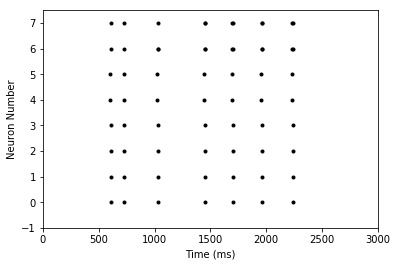

In [50]:
# Basic raster plot
plt.plot(spks[:, 0], spks[:, 1], '.k')
plt.xlim(0, config_file['run']['tstop'])
plt.ylim(-1, 7.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Number')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 6:</h3>
Zoom into speicific time window of raster to see interactions better.
<p>Hint: change plt.xlim()
</div>

Text(0,0.5,'Neuron Number')

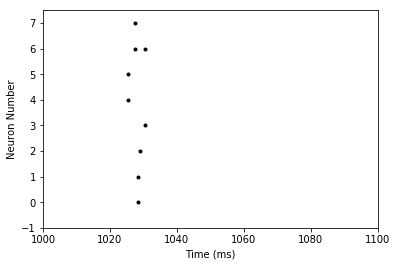

In [51]:
plt.plot(spks[:,0], spks[:, 1], '.k')
plt.xlim(1000, 1100)
plt.ylim(-1, 7.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Number')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h3>Plot membrane trace of node</h3>
Membrane traces are also stored and saved in a .h5 file format. Below we show how to access, load, and plot the membrane traces.
</div>

In [53]:
# Load the file for a node and see all the recorded variables
import h5py
h5_output_file = 'output/cell_vars.h5'
f = h5py.File(h5_output_file, 'r')
for key in f:
    if key.lower() == 'mapping':
        continue
    print('Variables recorded:', key)

Variables recorded: cai
Variables recorded: v


Text(0,0.5,'Membrane voltage (mV)')

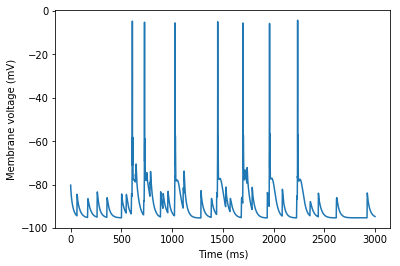

In [54]:
# Select the membrane voltage variable and plot it
node = 2
mem_vol = np.array(f['/v/data'])
time = np.arange(0, config_file['run']['tstop'], config_file['run']['dt'])
plt.plot(time, mem_vol[:,node])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h3>Excercise 7:</h3>
Plot the membrane potential of all biophysically detailed neurons in a subplot. Look at the difference in subthreshold activity between the excitatory and inhibitory cells (recalled only excitatory get input from the external population).
</div>

/allen/programs/braintv/workgroups/modelingsdk/local/miniconda3/envs/friday-harbor-py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


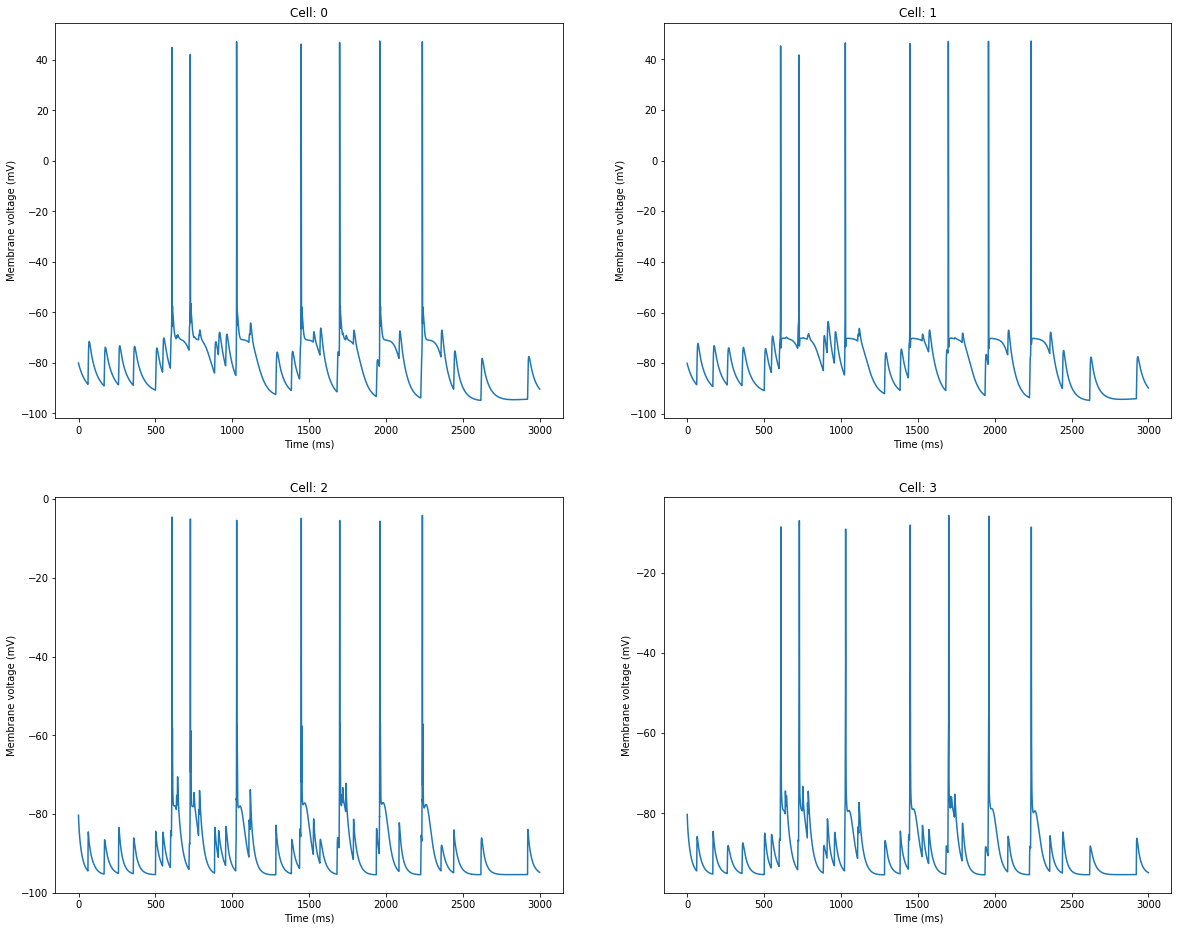

In [56]:
nodes = [0, 1, 2, 3]
plt.figure(figsize = (20, 16))
plt.subplot(2, 2, 1)
h5_handle = h5py.File('output/cell_vars.h5', 'r')
voltage_table = h5_handle['/v/data']
for i, node in enumerate(nodes):
    v_data = voltage_table[:, i]
    
    plt.subplot(2, 2, i + 1)
    mem_vol = np.array(v_data)
    time = np.arange(0, config_file['run']['tstop'], config_file['run']['dt'])
    plt.plot(time, mem_vol)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    plt.title('Cell: ' + str(node))


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h2>Homework exercises:</h2>
<p>1. Explore the directory structure created from this notebook that represents the network  
<p>2. Explore the directory components that was created for you and contains more cell types  
<p>3. Download and HDF5 viewer and explore the .h5 files created.  
<p>4. Simulate one biophysical neuron receiving a large number of balanced excitatory and inhibitory inputs. Choose a cell model other than Scnn1a or PV1. Explore the effects of changing the target locations (somatic, basal, apical) of the excitatory and inhibitory inputs.  
<p>5. We have another directory >>pointnet_notebook that shows how to use the same files and circuit created here to run a point neural network simulation. The simulator engine is NEST (http://www.nest-simulator.org/) and some changes had to be made to the config file and network description (documented in the notebook) based on NEST nomenclature requirements. Feel free to explore and play around with the notebook and NEST.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Project Ideas:</h2>
<p>1. Compare visual responses between the Layer 4 model and Brain Observatory.  

<p>2. Find an optimal kernel for converting spikes from the Layer 4 model to Ca2+ signal, to maximize the agreeement with the Brain Observatory data.  

<p>3. Build a small-scale point-neuron network model receiving visual inputs; run simulations to explore visual responses.  

<p>4. Build a small-scale point-neuron network; explore the effect of different connectivity rules on the spatio-temporal dynamics.  

<p>5. Build a population-statistics DiPDE model analogous to the biophysical Layer 4 model.  Investigate whether similar dynamics can be obtained.  

<p>6. Build a population-statistics DiPDE model of all cortical layers.  Explore cortical dynamics in simulations.  
</div>

In [ ]:
# commands to compile neuron modules safe to ignore if on AWS
# %%bash
# CURR_DIR=$(pwd)
# rm -rf components/mechanisms/x86_64/
# cd components/mechanisms/
# source ~/.bashrc
# nrnivmodl modfiles
# cd $CURR_DIR
